In [121]:
import numpy as np
import scipy.optimize as optimize
import scipy as sc
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

In [122]:
# Main 
"""
@ Params:
    R: a list of stock price
    k: number of latent components
@ Return:
    price_tplus1
    u_tplus1
    u_smooth
"""
def KalmanFilterForecast(R, k):
    r = 0.25*np.log(np.var(R,axis = 0,ddof=1))
    if k == 1:
        param0 = np.append(np.append(np.append(np.array(100),r,),100),r)
        
    if k == 2:
        param0 = np.append(np.append(np.append(np.array([100,100]),4*r),[-100,-100]),[r,r])
    def objective(params):
        Likelihood,_ = KalmanFilter(R,k,params)
        return Likelihood
    params_star = optimize.fmin(objective,param0)
    print(params_star)
    #params_star = optimize.minimize(objective,param0,method='CG')
    #params_star = params_star.values()[5]
    #print(params_star)
    u_smooth = KalmanSmoother(R, k, params_star)
#     Z = np.array(params_star[0])
#     H = np.exp(params_star[1]);
#     T = np.array(params_star[2])
#     Q = np.exp(params_star[3]);
    Z = 2/(1+np.exp(-params_star[0]))-1;
    H = np.exp(params_star[1]);
    T = 2/(1+np.exp(-params_star[2]))-1;
    Q = np.exp(params_star[3]);
      
    u_tplus1 = T*u_smooth[-1] + np.random.normal()*np.sqrt(Q)
    price_tplus1 = Z*u_tplus1 + np.random.normal()*np.sqrt(H)
    print('T*u_smooth[-1] is {}; Z*u_tplus1 is {}'.format(T*u_smooth[-1],Z*u_tplus1))
    Dev_Q = np.random.normal()*np.sqrt(Q)
    Dev_H = np.random.normal()*np.sqrt(H)
    return price_tplus1,u_tplus1,u_smooth,params_star,T,Z,Dev_Q,Dev_H

In [123]:
def KalmanFilter(R,k,params):
    S_length = R.shape[0]
    S = S_length+1
    if k == 1:
#         Z = np.array(params[0])
#         H = np.array(np.exp(params[1]))
#         T = np.array(params[2])
#         Q = np.array(np.exp(params[3]))
        Z = np.array(2/(1+np.exp(-params[0]))-1)
        H = np.array(np.exp(params[1]))
        T = np.array(2/(1+np.exp(-params[2]))-1)
        Q = np.array(np.exp(params[3]))
    if k == 2:
        Z = np.array([[2/(1+np.exp(-params[0]))-1,2/(1+np.exp(-params[1]))-1]])
        H = np.array(np.exp(params[2]))
        T = np.array([[2/(1+np.exp(-params[3]))-1,0],[0,2/(1+np.exp(-params[4]))-1]])
        Q = np.array([[np.exp(params[5]),0],[0,np.exp(params[6])]])
    u_predict = np.zeros((k,S));
    u_update = np.zeros((k,S));
    P_predict = np.zeros((k,k,S));
    P_update = np.zeros((k,k,S));
    v = np.zeros((1,S));
    F = np.zeros((1,S));
    KF_Dens = np.zeros((1,S));
    for i in range(S):
        if i == 0:
            P_update[:,:,i] = 1000*np.eye(k)
            P_predict[:,:,i] = T.dot(np.array(P_update[0][0][0]).dot(T.T))+Q
        else:
            F[0][i] = Z.dot(P_predict[:,:,i-1].dot(Z.T))+H
            v[0][i] = R.T.flatten()[i-1]-Z.dot(u_predict[:,i-1])
            u_update[:,i] = u_predict[:,i-1]+P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(v[0][i]))).flatten()
            u_predict[:,i] = T.dot(u_update[:,i])
            P_update[:,:,i] = P_predict[:,:,i-1]-P_predict[:,:,i-1].dot(Z.T.dot(np.linalg.inv([[F[0][i]]]).dot(Z.dot(P_predict[:,:,i-1]))))
            P_predict[:,:,i] = T.dot(P_update[:,:,i]).dot(T.T)+Q
            KF_Dens[0][i] = (1.0/2)*np.log(2*np.pi)+(1.0/2)*np.log(np.abs(F[0][i]))+(1.0/2)+v[0][i].T*np.linalg.inv([[F[0][i]]])*v[0][i]
    Likelihood = np.sum(KF_Dens)-KF_Dens[0][0]
    varargout = [u_update, P_update, P_predict, T]
    return Likelihood, varargout

In [124]:
def KalmanSmoother(R,k,params_star):
    _,vararg = KalmanFilter(R,k,params_star)
    u_update = vararg[0]
    P_update = vararg[1]
    P_predict = vararg[2]
    T = np.array(vararg[3])
    S = R.shape[0]+1
    u_smooth = np.zeros((k,S))
    P_smooth = np.zeros((k,k,S))
    u_smooth[:,S-1] = u_update[:,S-1]
    P_smooth[:,:,S-1] = P_update[:,:,S-1]    
    for t in reversed(range(1,S)): # 2 to S inverse sequence
        u_smooth[:,t-1] = u_update[:,t] + P_update[:,:,t].dot(T.T.dot(np.linalg.inv(P_predict[:,:,t]).dot((u_smooth[:,t]-T.dot(u_update[:,t])))))
        P_smooth[:,:,t-1] = P_update[:,:,t] + P_update[:,:,t].dot(T.T).dot(np.linalg.inv(P_predict[:,:,t])).dot((P_smooth[:,:,t]-P_predict[:,:,t])).dot(np.linalg.inv(P_predict[:,:,t])).dot(T).dot(P_update[:,:,t])
    u_smooth = u_smooth.flatten()[1:]
    return u_smooth

In [134]:
data = pd.read_csv('CrudeData.csv')
data.head(10)
# data=data.dropna()
# R=data["CRUDEOIL"].values
# #R=np.matrix(R)
# k=1
# R

,observation_date,CRUDEOIL
0,2014-12-31,55.27
1,2014-12-30,55.60
2,2014-12-29,57.86
3,2014-12-26,58.72
4,2014-12-24,58.67
5,2014-12-23,59.07
6,2014-12-22,58.31
7,2014-12-19,58.87
8,2014-12-18,58.81
9,2014-12-17,59.84


In [135]:
price_tplus1,u_tplus1,u_smooth,params_star,T,Z,Dev_Q,Dev_H = KalmanFilterForecast(R, k)
#KalmanFilterForecast(R, k)

Optimization terminated successfully.
         Current function value: 4773.733795
         Iterations: 188
         Function evaluations: 384
[321.52878749 -30.4578281  783.36356028   1.25624601]
T*u_smooth[-1] is 110.96000000000005; Z*u_tplus1 is 113.67622909008126


In [136]:
price_tplus1

113.67622895659974

In [94]:
params_star

[2.34, 3.41, 4.12, 5.22]

In [65]:
Keval=data["observation_date"].values
Keval

array(['2018-09-10', '2018-09-07', '2018-09-06', ..., '2011-03-18',
       '2011-03-17', '2011-03-16'], dtype=object)

In [66]:
date1 = datetime.date(2019,1,1)
date2 = datetime.date(2019,2,25)

In [68]:
for i in range((date2 - date1).days + 1):    
    atplus1 = T*u_tplus1 + Dev_Q
    ytplus = Z*atplus1 + Dev_H    
    u_tplus1 = atplus1          
    #print(date1+1)
    #print(u_tplus1)
    print(ytplus)
    
    
    

188.2573907183009
189.60656090077424
190.95573108324757
192.3049012657209
193.65407144819423
195.00324163066756
196.3524118131409
197.70158199561422
199.05075217808755
200.39992236056088
201.7490925430342
203.09826272550754
204.44743290798087
205.7966030904542
207.14577327292753
208.49494345540086
209.8441136378742
211.19328382034752
212.54245400282085
213.89162418529418
215.2407943677675
216.58996455024084
217.93913473271417
219.2883049151875
220.63747509766083
221.98664528013416
223.33581546260748
224.68498564508081
226.03415582755414
227.38332601002747
228.7324961925008
230.08166637497413
231.43083655744746
232.7800067399208
234.12917692239412
235.47834710486745
236.82751728734078
238.1766874698141
239.52585765228744
240.87502783476077
242.2241980172341
243.57336819970743
244.92253838218076
246.2717085646541
247.62087874712742
248.97004892960075
250.31921911207408
251.6683892945474
253.01755947702074
254.36672965949407
255.7158998419674
257.0650700244407
258.414240206914
259.7634103

In [70]:
predData=pd.read_csv('PredictedCrudePrice.csv')

In [71]:
predData

,observation_date,PredictedPrice
0,2019-01-01,188.257391
1,2019-01-02,189.606561
2,2019-01-03,190.955731
3,2019-01-04,192.304901
4,2019-01-05,193.654071
5,2019-01-06,195.003242
6,2019-01-07,196.352412
7,2019-01-08,197.701582
8,2019-01-09,199.050752
9,2019-01-10,200.399922


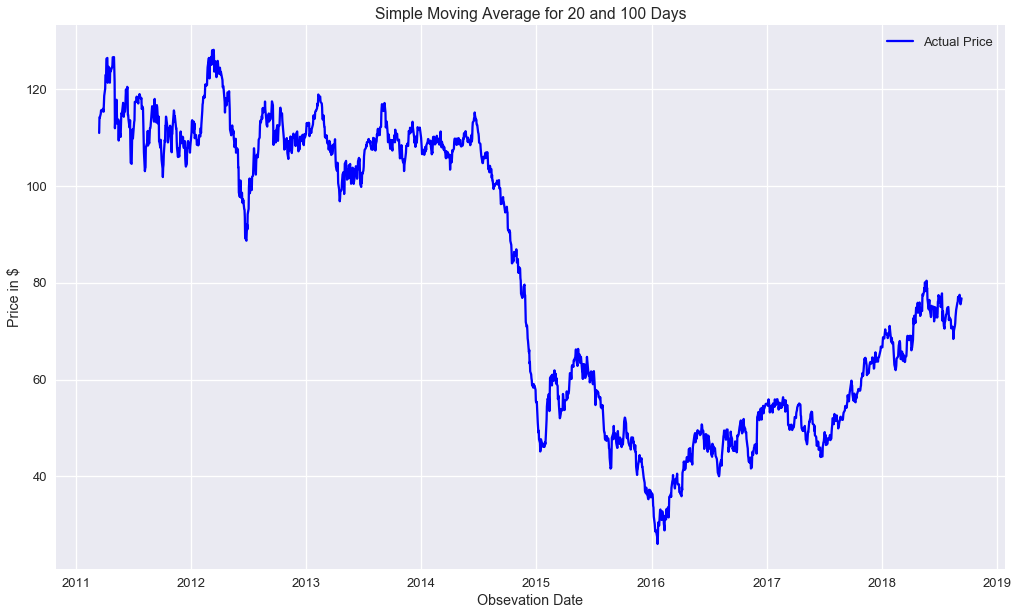

In [73]:
data = pd.read_csv('CrudeData.csv')
import datetime
sns.set(style='darkgrid', context='talk', palette='Dark2') # Setting the style of the plots.
my_year_month_fmt = mdates.DateFormatter('%y/%m/%d')
data['observation_date'] = pd.to_datetime(data['observation_date'])
data.index = data['observation_date']
del data['observation_date']

start_date = '2018-12-10'
#end_date = '2018-01-10'
end_date = '2011-03-16'

fig, ax = plt.subplots(figsize=(17,10)) # Setting the size of the plot.


#ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'SP500'], label='SP500', color = 'green')
ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'CRUDE OIL'], label='Actual Price', color = 'blue')
#ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Oil'], label = '20-days SMA', color = 'red')
#ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'Oil'], label = '100-days SMA', color = 'black')


ax.legend(loc='best')
ax.set_title('Simple Moving Average for 20 and 100 Days')
ax.set_xlabel('Obsevation Date')
ax.set_ylabel('Price in $')
#ax.xaxis.set_major_formatter(my_year_month_fmt)


 # Creating a custom data formatter.


In [52]:
predData.head(10)

,observation_date,PredictedPrice
0,2019-01-01,19.20
1,2019-01-02,19.20
2,2019-01-03,19.28
3,2019-01-04,19.45
4,2019-01-05,19.45
5,2019-01-06,17.65
6,2019-01-07,18.19
7,2019-01-08,18.08
8,2019-01-09,18.80
9,2019-01-10,19.28


In [98]:
#predData=pd.read_csv('PredictedCrudePrice.csv')
#import datetime
#sns.set(style='darkgrid', context='talk', palette='Dark2') # Setting the style of the plots.
#my_year_month_fmt = mdates.DateFormatter('%y/%m/%d')
#predData['observation_date'] = pd.to_datetime(predData['observation_date'])
#predData.index = predData['observation_date']
#del predData['observation_date']

#start_date = '2019-01-01'
#end_date = '2019-12-31'

#fig, ax = plt.subplots(figsize=(17,10)) # Setting the size of the plot.


#ax.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'SP500'], label='SP500', color = 'green')
#ax.plot(predData.loc[start_date:end_date, :].index, predData.loc[start_date:end_date, 'PredictedPrice'], label='Predicted Price', color = 'blue')
#ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'Oil'], label = '20-days SMA', color = 'red')
#ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'Oil'], label = '100-days SMA', color = 'black')


#ax.legend(loc='best')
#ax.set_title('Simple Moving Average for 20 and 100 Days')
#ax.set_xlabel('Obsevation Date')
#ax.set_ylabel('Price in $')
#ax.xaxis.set_major_formatter(my_year_month_fmt)


 # Creating a custom data formatter.


In [75]:
atplus1 = T*u_tplus1 + Dev_Q
print(atplus1)
ytplus = Z*atplus1 + Dev_H
ytplus
#range((date2 - date1).days + 1)

263.81092122396467


263.8109209368072

In [76]:
from datetime import datetime
from dateutil.parser import parse
import pandas as pd

In [99]:
#Observation_Dates = [1000]

#for i in range(len(Keval)):
 #   Observation_Dates.append(i)
  #  Observation_Dates[i] = datetime.strptime(Keval[i], '%d/%m/%Y')

In [78]:
print(price_tplus1)

111.35469066810576


In [ ]:
Observation_Dates

In [79]:
print(u_tplus1)

262.46175104149137


In [80]:
u_smooth=-u_smooth
print(u_smooth)

[ -75.55  -75.67  -76.68 ... -114.18 -110.96 -110.96]


In [100]:
#fig = plt.figure(figsize=(18,10))
#plt.plot(price_tplus1,'y',label = "price_tplus1")
#plt.plot(u_tplus1,'r',label = "u_tplus1")
#plt.plot(u_smooth,'b',label = "u_smooth")
#plt.plot(R,'g',label = "price")
#plt.show()


In [82]:
params=np.matrix([[2.34],[3.24],[5.12],[6.34]])

In [83]:
KalmanFilter(R, k, params)

(8355.153297452005,
 [array([[  0.        ,  90.92245189,  91.55010735, ..., 138.41738492,
          138.41930767, 134.74272493]]),
  array([[[1000.        ,   36.68791932,   35.37526278, ...,
             35.37082235,   35.37082235,   35.37082235]]]),
  array([[[1543.1753818 ,  602.61762794,  601.33597757, ...,
            601.33164203,  601.33164203,  601.33164203]]]),
  array([[0.98811896]])])

In [84]:
params_star = [2.34,3.41,4.12,5.22]

In [85]:
u_smooth=KalmanSmoother(R, k, params_star)
u_smooth

array([ 91.49292565,  91.92001281,  92.94940687, ..., 137.94907743,
       135.08644468, 134.38519042])

In [86]:
import matplotlib.pyplot as plt

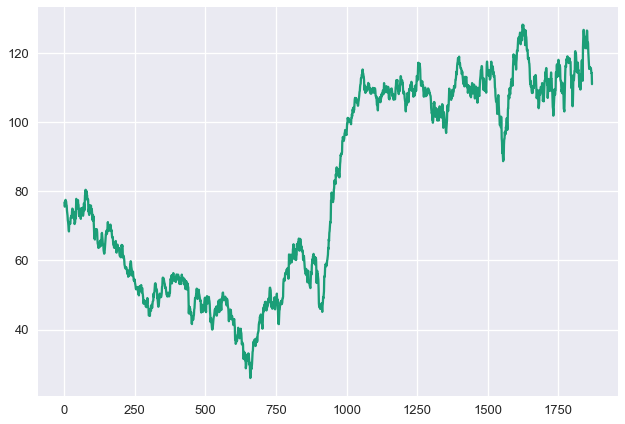

In [87]:
plt.plot(R)
plt.show()

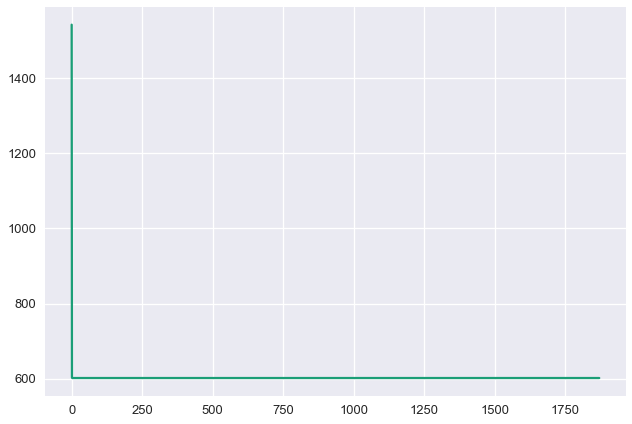

In [88]:
_, varargout = KalmanFilter(R, k, params)
u_update, P_update, P_predict, T = varargout
P_predict = np.squeeze(np.asarray(P_predict))
plt.plot(P_predict)
plt.show()

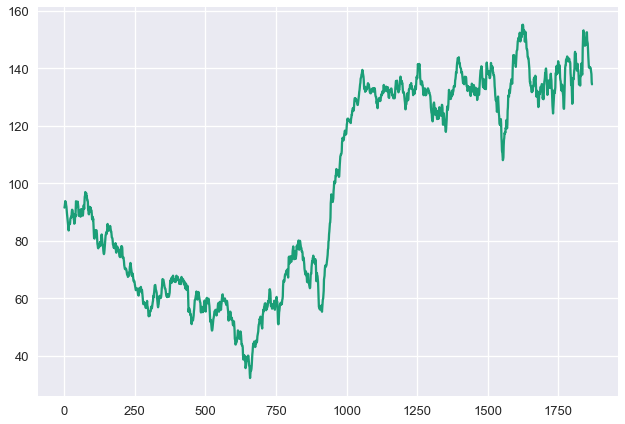

In [89]:
plt.plot(u_smooth)
plt.show()